# Weather Forecast Using Machine Learning 


Data Provided By:
https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00516

OVERVIEW

The following is a description of the global surface summary of day product produced by the 
National Centers for Environmental Information (NCEI) in Asheville, NC.  The input data used in 
building these daily summaries are the Integrated Surface Data (ISD), which includes global 
data obtained from the USAF Climatology Center, located in the Federal Climate Complex with 
NCEI. The latest daily summary data are normally available a few days after the date-time of the 
observations used in the daily summaries. The online data files begin with 1929. Over 9000 
stations' data are typically available.  

The headers used in csv files and definition of each daily element included in the dataset (as 
available from each station) are as follows:

TEMP - Mean temperature (.1 Fahrenheit)
DEWP - Mean dew point (.1 Fahrenheit)
SLP - Mean sea level pressure (.1 mb)
STP - Mean station pressure (.1 mb)
VISIB - Mean visibility (.1 miles)
WDSP – Mean wind speed (.1 knots)
MXSPD - Maximum sustained wind speed (.1 knots)
GUST - Maximum wind gust (.1 knots)
MAX - Maximum temperature (.1 Fahrenheit)
MIN - Minimum temperature (.1 Fahrenheit)
PRCP - Precipitation amount (.01 inches)
SNDP - Snow depth (.1 inches)

#### Main Query

The first Step is to get the dataset to this work. The data is hosted at Google Cloud Platform and will be used Google BigQuery API to get data from the server

Main Goal:
    Get Data from all locations related to Brazil from 2000-2016

In [1]:
from google.cloud import bigquery
import pandas as pd
import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= r"C:\Users\arthu\OneDrive\Ambiente de Trabalho\Projects\Google Cloud Data\weather_forecast\keys.json"
client = bigquery.Client()
plt.style.use('fivethirtyeight')
query = """
    SELECT DATE(CAST(T.year AS INT64),CAST(T.mo AS INT64),CAST(T.da AS INT64)) as Date,AVG(T.temp) AS Temp,AVG(IF(T.prcp=99.99,NULL,T.prcp)) as Prec, AVG(IF(T.gust=999.9,NULL,T.gust)) as Vent
    FROM `fh-bigquery.weather_gsod.gsod*` T LEFT JOIN `fh-bigquery.weather_gsod.stations` L
    ON T.stn = L.usaf
    WHERE L.country = "BZ" AND  T._TABLE_SUFFIX BETWEEN '2000' AND '2016'
    GROUP BY 1
"""


dataset = pd.read_gbq(query)
dataset

,Date,Temp,Prec,Vent
0,2016-01-01,80.535849,0.055556,24.169231
1,2016-01-02,79.125510,0.115167,27.886667
2,2016-01-05,79.220909,0.106517,25.885714
3,2000-09-11,78.160465,0.115493,27.671429
4,2000-11-23,79.106977,0.060000,42.900000
...,...,...,...,...
5849,2005-05-02,75.183696,0.000000,NaN
5850,2005-01-29,78.632000,0.000000,25.100000
5851,2005-07-17,72.339286,0.000000,34.450000
5852,2005-03-27,77.681132,0.000000,NaN


#### Mesurement Locations

A Second Query was set in order to ilustrate where the measures from data was collected

In [2]:
from ipyleaflet import Map, CircleMarker

locations = """
    SELECT name, (CAST(lat as INT64)/1000) as Lat, (CAST(lon AS INT64)/1000) as Lon
    FROM `fh-bigquery.weather_gsod.stations` WHERE country ="BZ"
"""

locationsData = pd.read_gbq(locations)
locationsData

map = Map(center=[-23,-91.3],zoom=3)
for city in locationsData.itertuples():
    marker = CircleMarker(location=[city.Lat,city.Lon], title=city.name, radius=2)
    map.add_layer(marker)
map

Map(center=[-23, -91.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

#### Dataset Structure

The Dataset needed some fomatting before the analysis starts.
1- Convert Index  to Datetime form
2- Convert Temperature from Farenheit to Celsius

In [3]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values(by='Date')
dataset  = dataset.set_index(dataset['Date'])
dataset['Temp'] = (dataset['Temp']-32)*(5/9)
dataset

,Date,Temp,Prec,Vent
Date,,,,
2000-01-01,2000-01-01,24.983007,0.382321,25.100000
2000-01-02,2000-01-02,24.669974,0.265593,24.420000
2000-01-03,2000-01-03,24.290698,0.241579,29.550000
2000-01-04,2000-01-04,25.005291,0.199032,NaN
2000-01-05,2000-01-05,25.544574,0.234179,21.950000
...,...,...,...,...
2016-01-09,2016-01-09,26.291383,0.112419,25.063636
2016-01-10,2016-01-10,26.498316,0.186393,27.108333
2016-01-11,2016-01-11,26.855051,0.170694,24.626667


#### General Data Visualization
    
General univariable visualization from Temperature data. Descriptive Statistics also

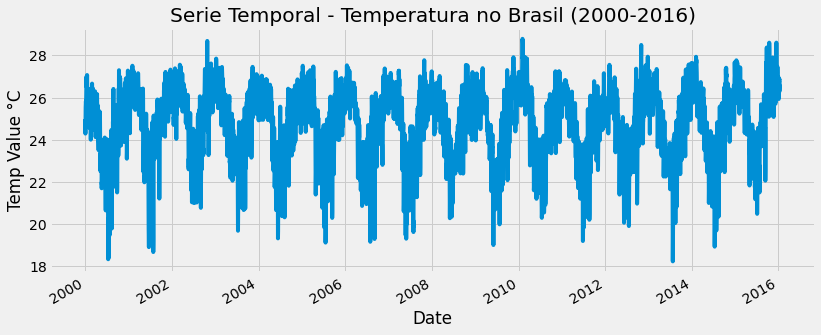

In [4]:
plt.figure(figsize=(12.2,5))
dataset['Temp'].plot()
plt.title('Serie Temporal - Temperatura no Brasil (2000-2016)')
plt.xlabel('Date')
plt.ylabel('Temp Value °C')
plt.show()

<Figure size 576x864 with 0 Axes>

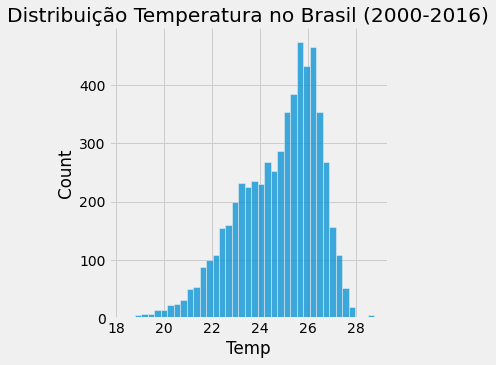

In [9]:
import seaborn as sns

plt.figure(figsize=(8,12))
sns.displot(dataset['Temp'])
plt.title('Distribuição Temperatura no Brasil (2000-2016)')
plt.show()

Moving Average Smoothness

In [6]:
dataset['MVA Rolling 7'] = dataset['Temp'].rolling(7).mean()
dataset

,Date,Temp,Prec,Vent,MVA Rolling 7
Date,,,,,
2000-01-01,2000-01-01,24.983007,0.382321,25.100000,NaN
2000-01-02,2000-01-02,24.669974,0.265593,24.420000,NaN
2000-01-03,2000-01-03,24.290698,0.241579,29.550000,NaN
2000-01-04,2000-01-04,25.005291,0.199032,NaN,NaN
2000-01-05,2000-01-05,25.544574,0.234179,21.950000,NaN
...,...,...,...,...,...
2016-01-09,2016-01-09,26.291383,0.112419,25.063636,26.354761
2016-01-10,2016-01-10,26.498316,0.186393,27.108333,26.435668
2016-01-11,2016-01-11,26.855051,0.170694,24.626667,26.515682


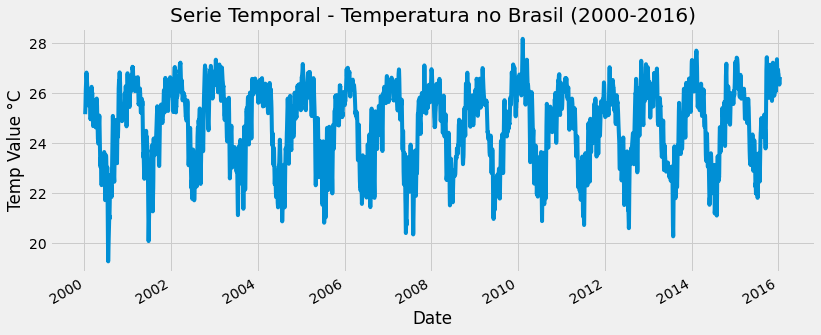

In [7]:
plt.figure(figsize=(12.2,5))
dataset['MVA Rolling 7'].plot()
plt.title('Serie Temporal - Temperatura no Brasil (2000-2016)')
plt.xlabel('Date')
plt.ylabel('Temp Value °C')
plt.show()

#### Time Series Aditive Decomposion

Seazonality and Trend Analysis

<AxesSubplot:title={'center':'Sazonalidade'}, xlabel='Date'>

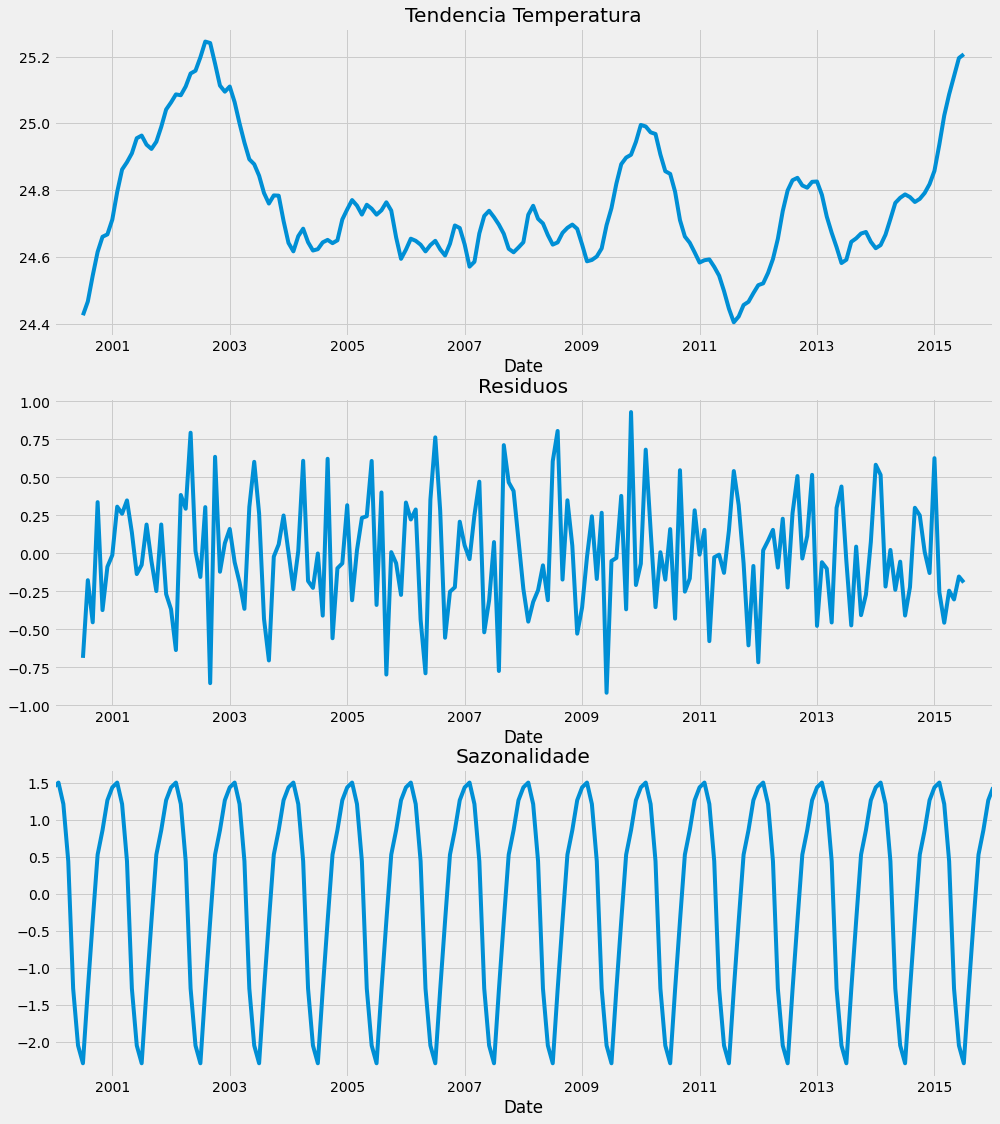

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

mva = dataset['MVA Rolling 7'].dropna()
mva = mva.groupby(pd.Grouper(freq="M")).mean()
res = seasonal_decompose(mva,period=12)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,18))
ax1.set_title('Tendencia Temperatura')
res.trend.plot(ax=ax1)
ax2.set_title('Residuos')
res.resid.plot(ax=ax2)
ax3.set_title('Sazonalidade')
res.seasonal.plot(ax=ax3)